# Winter comparison

This notebook calculates mean monthly values for each data variable, and then compares mean values between winter 2018-19 and winter 2019-20. This allows us to visualize any differences between the two winter seasons. 

# 1) Read data 
Here, we set the start and end years that define our analysis time period. We read in the ICESat-2 monthly files and the book dataset (produced in the data wrangling notebook) from the google storage bucket. You can also set interpolation preferences for the ICESat-2 data, which has some holes. By setting `interpolation=True`, the code calls an interpolation function that is defined in the utils module. Interpolation takes some time to run; to go through the notebook faster, set `interpolation=False`. 

In [4]:
# Import notebook dependencies
import os
import xarray as xr
import numpy as np
import pandas as pd
import utils # See utils module in github repository
import warnings # Remove warnings to improve display
warnings.filterwarnings('ignore')

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
from textwrap import wrap
import matplotlib as mpl
import matplotlib.pyplot as plt

GeoAxes._pcolormesh_patched = Axes.pcolormesh
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 100

In [5]:
# Set desired date range 
start_year = "2018"
end_year = "2020"
winter_months = utils.getWinterDateRange(start_year, end_year)

# Read book data 
book_ds = utils.read_book_data()
book_ds = book_ds.sel(time = winter_months) # Get winter months

# Read ICESat-2 data 
is2_ds = utils.read_is2_data() 
is2_ds = is2_ds.sel(time = winter_months) # Get winter months

# Decide whether or not to interpolate the ICESat-2 data or use the raw product, which has some holes in the data
interpolate = True
if (interpolate == True): 
    print("Interpolating ICESat-2 data...")
    cdr_da = book_ds["seaice_conc_monthly_cdr"] # Get CDR data
    is2_ds = utils.is2_interp2d(is2_ds, cdr_da, method='nearest', interp_var='all')
    print("Complete!")
    
# Combine datasets 
ds = xr.merge([is2_ds, book_ds])
ds = ds.drop_vars("projection")

Interpolating ICESat-2 data...
Complete!


# 2) Restrict data to the Inner Arctic
The Inner Arctic is defined as the combined area of the Central Arctic, Beaufort Sea, Chukchi Sea, E Siberian Sea and the Laptev Sea. See the mapping notebook for more detail on this region and the methods used to restrict the data. 

In [6]:
regionKeyList = [10,11,12,13,15] #Inner Arctic
ds = utils.restrictRegionally(ds, regionKeyList)

Regions selected: Inner Arctic


# 3) Visualize mean differences
Compute mean values for each winter season, and plot.<br><br>
Click the + button to expand the functions used to compute means and plot the data

In [37]:
def plot_monthly_means(da, start_year, end_year, da_uncertainty=None, show_uncertainty=True):
    """ Generate a line plot of winter monthly means for all winters included in the dataset. DataArray must contain x,y as dimensions. 
    
    Args: 
        da (xr.DataArray): data to compute mean for 
        start_year (str): year to start computation for (i.e. "2018")
        end_year (str): year to end computation for (i.e. "2019")
        show_ucertainty (bool, optional): show detrended uncertainty (default to True)
        da_uncertainty (xr.DataArray, optional): uncertainty corresponding to da. If not inputted, the function will compute detrended uncertainty (default to None)
        
    Returns: 
        Figure displayed in notebook 
    
    """
    fig, ax = plt.subplots(figsize=(7,5))
    curr_yr = int(start_year)
    while curr_yr < int(end_year):
        try: 
            winter_n = utils.getWinterDateRange(start_year=str(curr_yr), end_year=str(curr_yr+1)) # Get winter season 
            winter_monthly_mean = da.sel(time=winter_n).mean(dim=["x","y"]).values # Compute mean
        except: 
            break
        
        # Plot lines 
        winter_str = "winter "+str(curr_yr)+'-'+str(curr_yr+1)
        ax.plot(winter_n.strftime("%b"), winter_monthly_mean, marker="o", label=winter_str)
        gridlines = plt.grid(b = True, linestyle = '--', alpha = 0.4) # Add gridlines 
        
        # Show uncertainty
        if show_uncertainty: 
            if da_uncertainty is None: 
                da_mean_unc = da.sel(time=winter_n).std(dim=["x","y"]).values
                unc_descrip = '+/-1 std'
            else: 
                da_mean_unc = da_uncertainty.sel(time=winter_n).mean(dim=["x","y"]).values
                unc_descrip = 'uncertainty'
            ax.fill_between(winter_n.strftime("%b"), winter_monthly_mean-da_mean_unc, winter_monthly_mean+da_mean_unc, alpha=0.1, edgecolor=None, label=winter_str+" "+unc_descrip)  

        try: # Try adding attributes for name and units as ylabel
            ylabel_str = "\n".join(wrap(da.attrs["long_name"]+" ("+da.attrs["units"]+")", 40))
            plt.ylabel(ylabel_str)
        except: # Leave ylabel blank if not 
            pass
        
        curr_yr+=1
        
    plt.legend(fontsize="small") # Add legend
    plt.show()

In [38]:
def compute_winter_means(da, start_year, end_year):
    """ Compute gridcell mean winter values for a given data variable 
    If start_year=2018 and end_year=2020, the function will return an xr.DataArray with two time dimension components for each winter season (winter 18-19 and winter )
    
    Args: 
        da (xr.DataArray): data to compute mean for 
        start_year (str): year to start computation for (i.e. "2008")
        end_year (str): year to end computation for (i.e. "2009")
        
    Returns: 
        var_merged_da (xr.DataArray): mean of da for each winter season 
    
    """
    curr_year = int(start_year)
    yrly_means = []
    while curr_year < int(end_year):
        winter = utils.getWinterDateRange(curr_year, curr_year+1)
       
        xr_winter_mean = da.sel(time=winter).mean(dim=["time"])
        xr_winter_mean = xr_winter_mean.assign_attrs(da.attrs)
        xr_winter_mean.name = da.name + "_mean"
        xr_winter_mean = xr_winter_mean.assign_coords({"time":"winter_"+str(curr_year)+"-"+str(curr_year+1)})
        xr_winter_mean = xr_winter_mean.expand_dims("time")
        
        yrly_means.append(xr_winter_mean)
        curr_year +=1
    var_merged = xr.merge(yrly_means)
    var_merged_da = var_merged[xr_winter_mean.name]
    return var_merged_da

In [39]:
def arcticComparisonMaps(data1, data2, plot_diff=True, vmin=None, vmax=None, vmin_diff=None, vmax_diff=None, cmap="viridis", title1="data_1", title2="data_2"):
    """ Plot comparison maps for two xr.DataArrays, along with gridcell difference 
    Both input DataArrays must be on the same grid and contain the coordinates latitude and longitude
    
    Args: 
        data1 (xr.DataArray): data to plot on leftmost plot. 
        data2 (xr.DataArray): data to plot on middle plot
        plot_diff (bool, optional): plot gridcell difference (data1 - data2) on a third map? (default to True)
        vmin (float, optional): minimum value to use colorbar (default to 1st percentile of data1)
        vmax (float, optional): maximum value to use colorbar (default to 99th percentile of data1)
        vmin_diff (float, optional): minimum value to use for plotting data range (default to mapping default, with 0 at center)
        vmax_diff (float, optional): maximum value to use for plotting data range (default to mapping default, with 0 at center)
        title1 (str, optional): title to give plot of data1 (default to "data1")
        title2 (str, optional): title to give plot of data2 (default to "data2")
        cmap (str, optional): colormap to use (default to viridis)
        
    Returns: 
        figure displayed in notebook 
        
    """

    # Compute min and max for plotting 
    vmin = vmin if vmin is not None else round(np.nanpercentile(data1.values, 1),1)
    vmax = vmax if vmax is not None else round(np.nanpercentile(data1.values, 99),1) 
        
    # Plot
    titles = [title1,title2]
    num_columns = 3 if (plot_diff==True) else 2
    fig, axes = plt.subplots(1, num_columns, figsize=(16,6), subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=-45)})
    im1 = data1.plot(x='longitude', y='latitude', ax=axes[0], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, zorder=8, cbar_kwargs = {'orientation':'horizontal', 'pad':0.02, 'extend':'both'})
    im2 = data2.plot(x='longitude', y='latitude', ax=axes[1], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, zorder=8, cbar_kwargs = {'orientation':'horizontal', 'pad':0.02, 'extend':'both'})
     
    if plot_diff: # Plot gricell difference
        gridcell_diff = data2 - data1
        diff_im = gridcell_diff.plot(x='longitude', y='latitude', ax=axes[2], transform=ccrs.PlateCarree(), vmin=vmin_diff, vmax=vmax_diff, zorder=8, cmap='coolwarm', cbar_kwargs={'orientation':'horizontal','pad':0.02,'extend':'both','label':'difference'})
        titles.append("Griddcell Difference")
    
    for ax, title in zip(axes,titles): # Add title and features to axes 
        ax.set_title("\n".join(wrap(title, 40)), fontsize = 13, y = 1, fontweight = 'medium')
        ax.coastlines(linewidth=0.15, color = 'black', zorder = 10) # Coastlines
        ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5)    # Land
        ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5)  # Lakes
        ax.gridlines(draw_labels=False, linewidth=0.25, color='gray', alpha=0.7, linestyle='--', zorder=6) # Gridlines
        ax.set_extent([-179, 179, 50, 90], crs=ccrs.PlateCarree()) # Set extent to zoom in on Arctic

    plt.show() # Show fig in notebook 

## ICESat-2 sea ice thickness

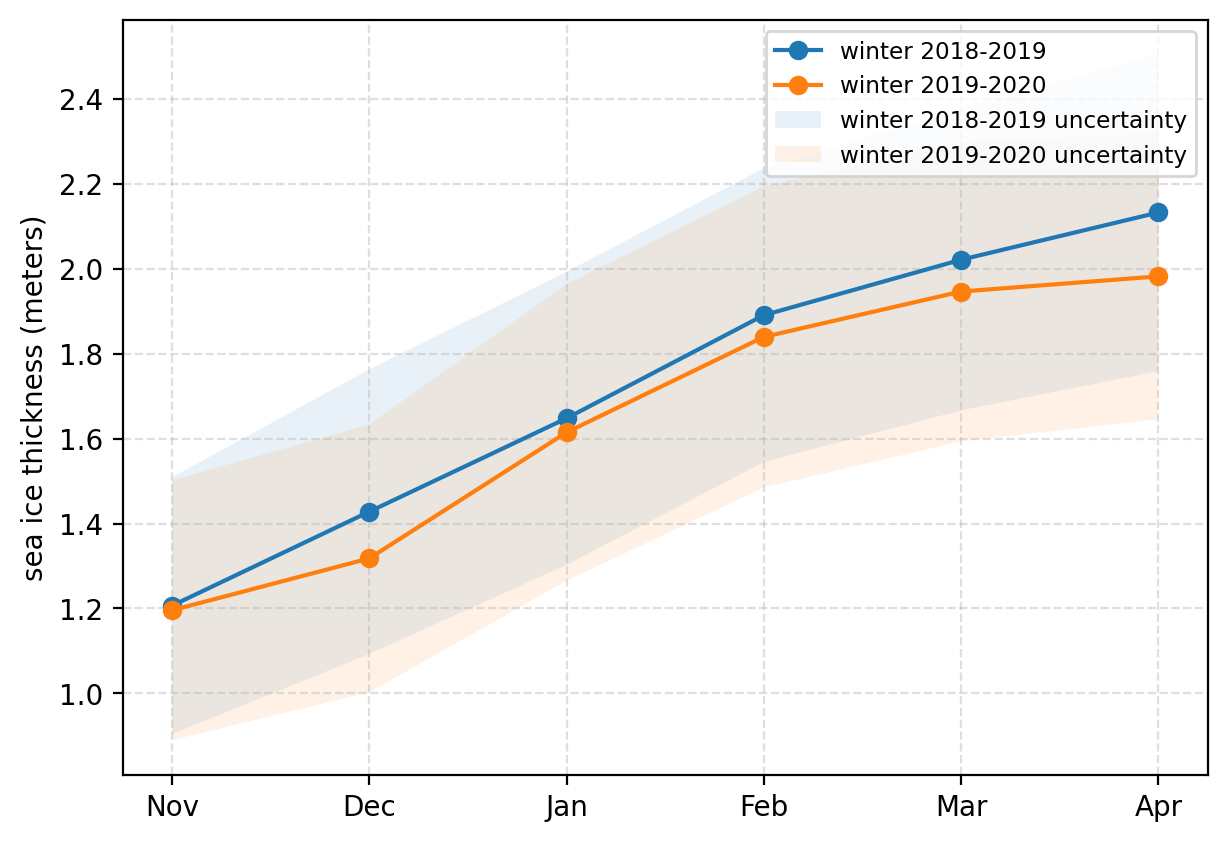

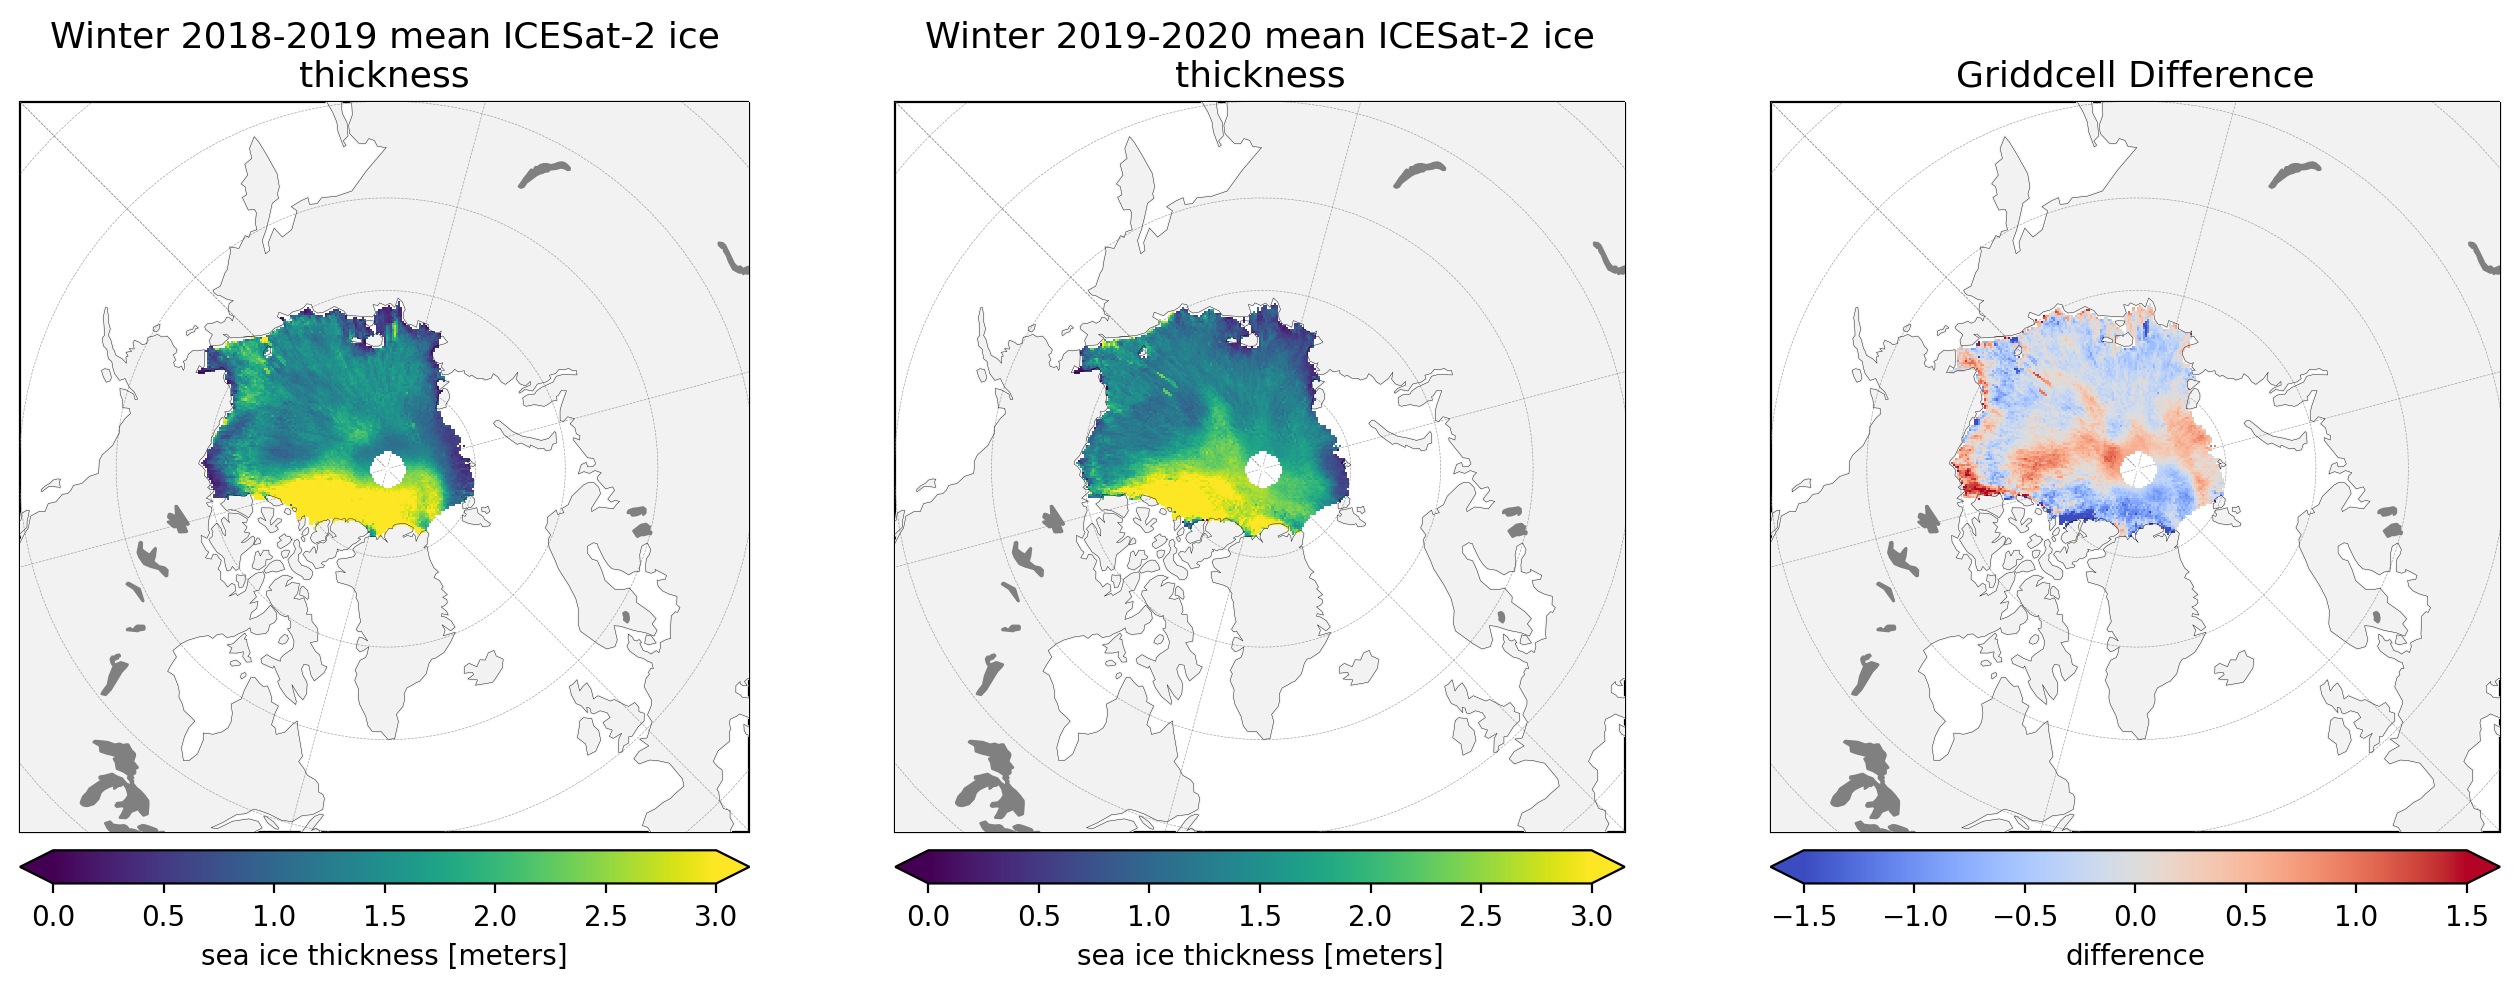

In [40]:
da = ds["ice_thickness"]
plot_monthly_means(da, start_year=start_year, end_year=end_year, da_uncertainty=ds["ice_thickness_unc"]) # Generate line plot

da_mean = compute_winter_means(da, start_year=start_year, end_year=end_year) # Compute gridcell seasonal mean 
arcticComparisonMaps(data1=da_mean.isel(time=0), title1="Winter "+ start_year + "-" + str(int(start_year)+1) + " mean ICESat-2 ice thickness", 
                     data2=da_mean.isel(time=1), title2="Winter "+ str(int(start_year)+1) + "-" + str(int(start_year)+2) + " mean ICESat-2 ice thickness", 
                     vmin=0, vmax=3, vmin_diff=-1.5, vmax_diff=1.5)

## PIOMAS sea ice thickness 

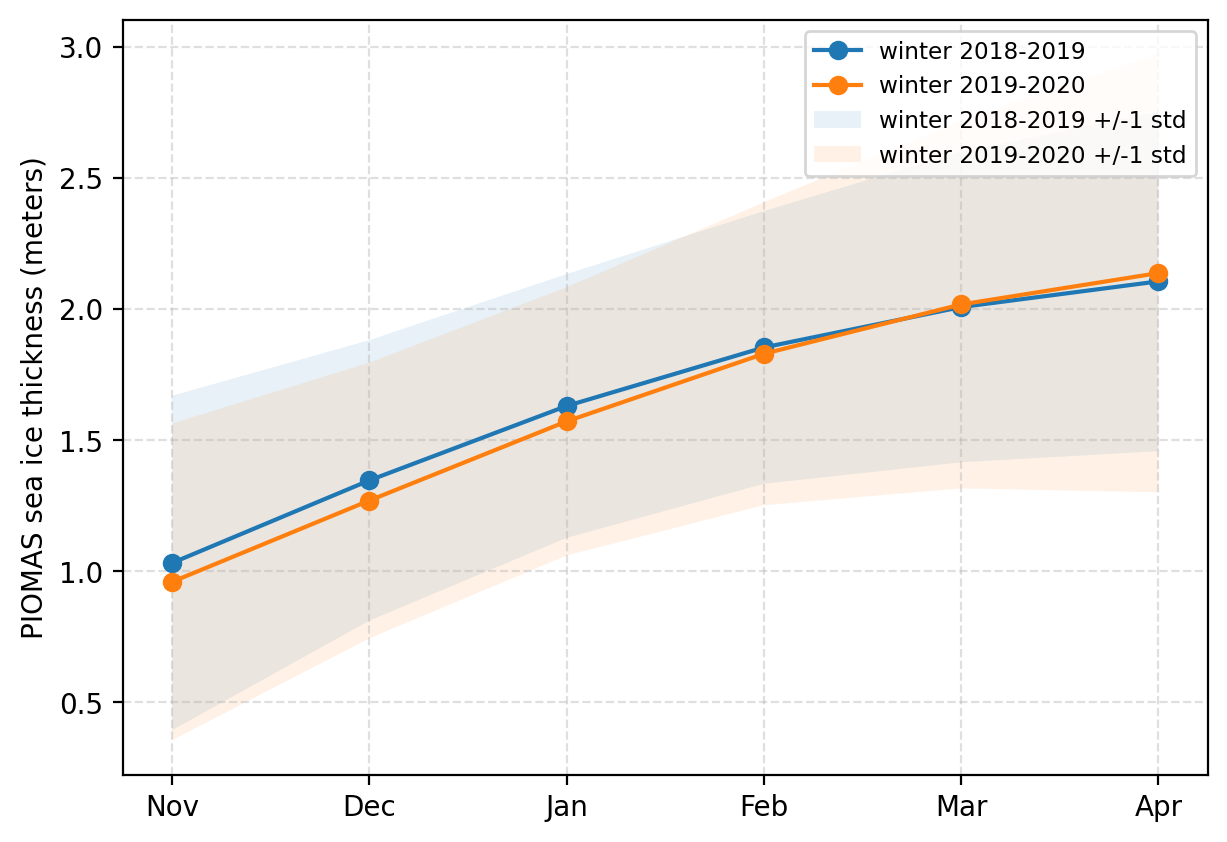

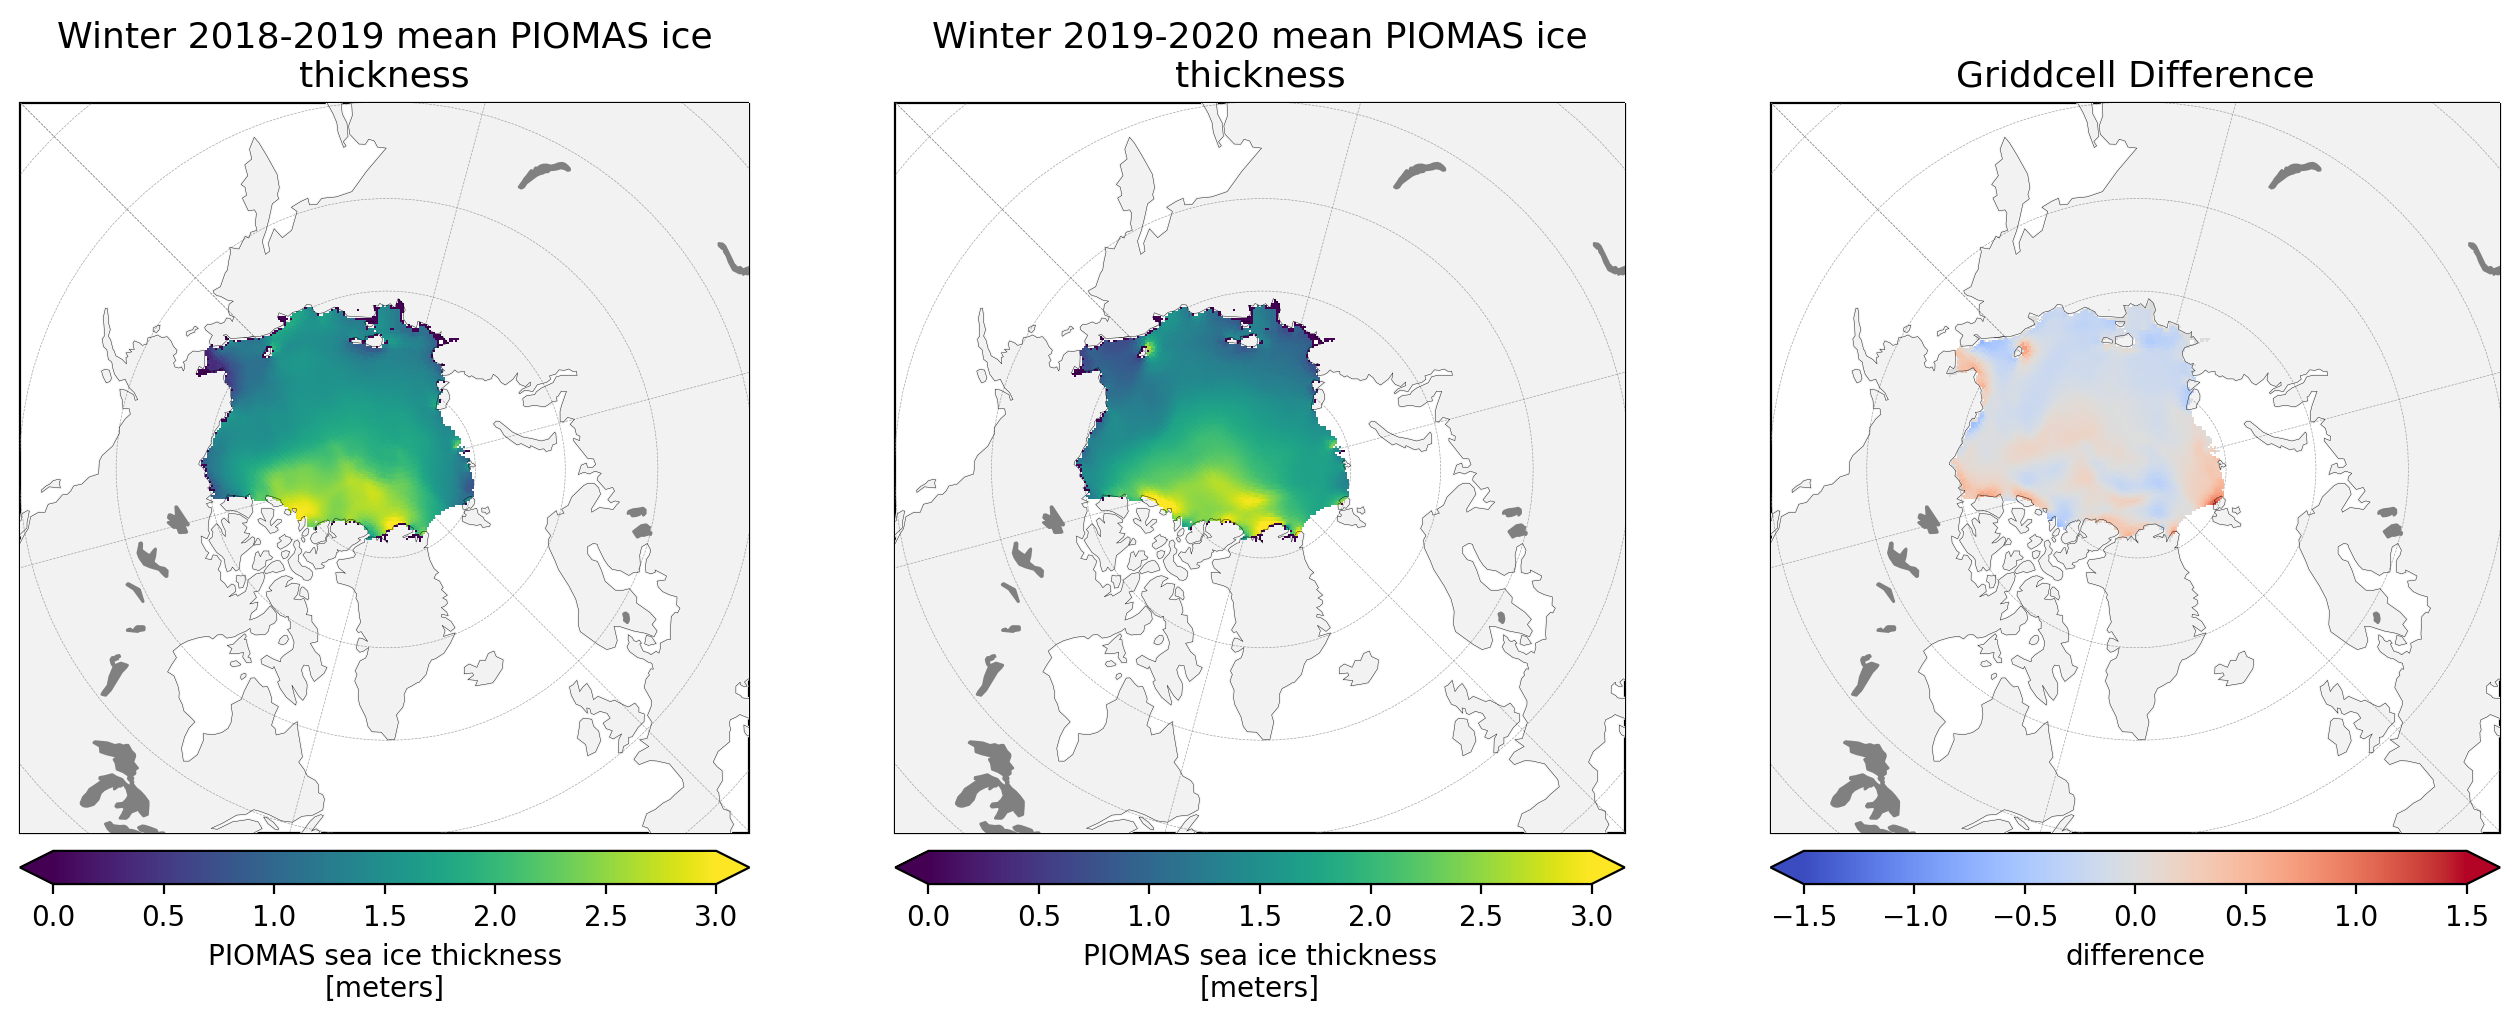

In [41]:
da = ds["piomas_ice_thickness"]
plot_monthly_means(da, start_year=start_year, end_year=end_year) # Generate line plot

da_mean = compute_winter_means(da, start_year=start_year, end_year=end_year) # Compute gridcell seasonal mean 
arcticComparisonMaps(data1=da_mean.isel(time=0), title1="Winter "+ start_year + "-" + str(int(start_year)+1) + " mean PIOMAS ice thickness", 
                     data2=da_mean.isel(time=1), title2="Winter "+ str(int(start_year)+1) + "-" + str(int(start_year)+2) + " mean PIOMAS ice thickness", 
                     vmin=0, vmax=3, vmin_diff=-1.5, vmax_diff=1.5)

## ICESat-2 sea ice thickness uncertainty

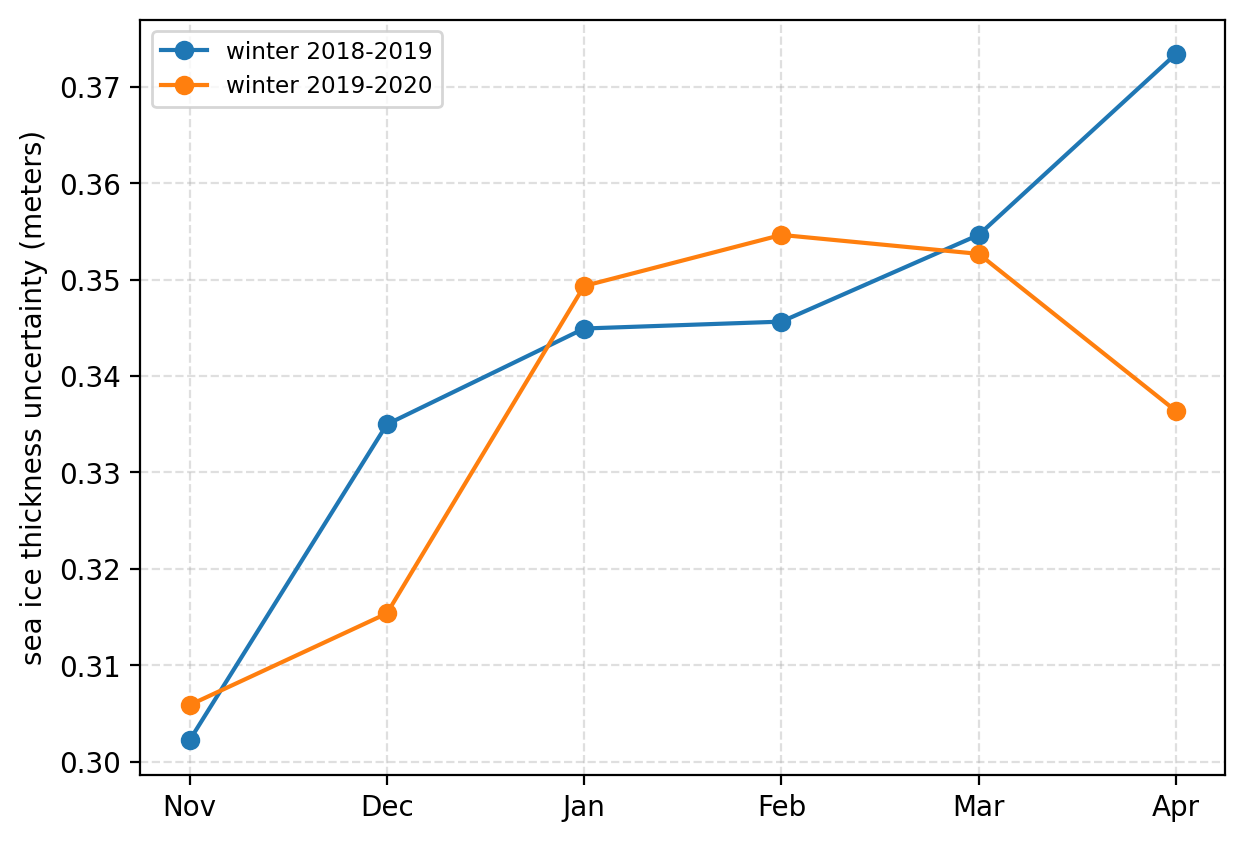

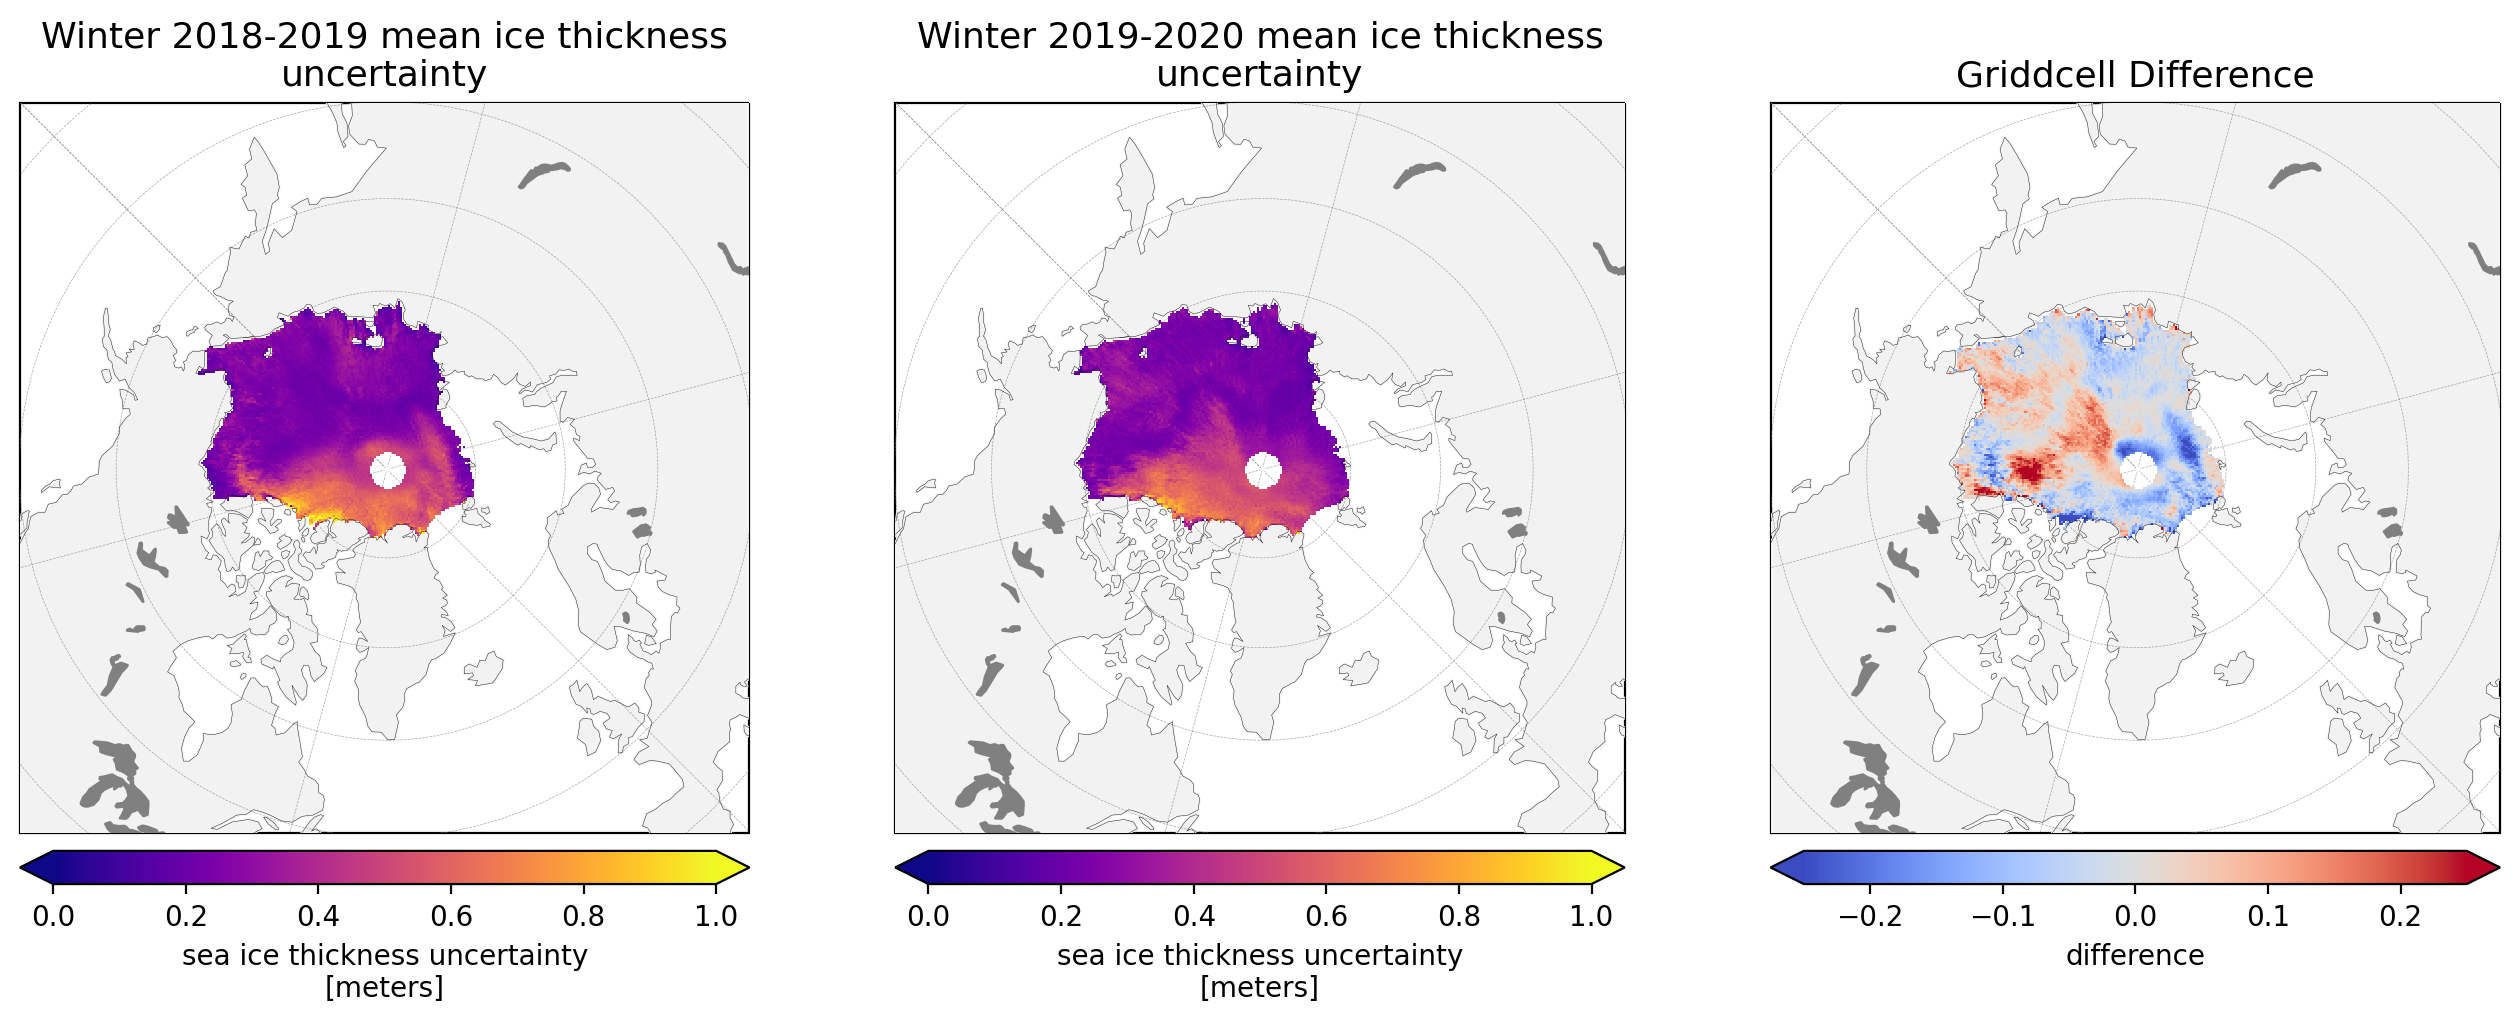

In [45]:
da = ds["ice_thickness_unc"]
plot_monthly_means(da, start_year=start_year, end_year=end_year, show_uncertainty=False) # Generate line plot

da_mean = compute_winter_means(da, start_year=start_year, end_year=end_year) # Compute gridcell seasonal mean 
arcticComparisonMaps(data1=da_mean.isel(time=0), title1="Winter "+ start_year + "-" + str(int(start_year)+1) + " mean ice thickness uncertainty", 
                     data2=da_mean.isel(time=1), title2="Winter "+ str(int(start_year)+1) + "-" + str(int(start_year)+2) + " mean ice thickness uncertainty", 
                    vmin=0, vmax=1, vmin_diff=-0.25, vmax_diff=0.25, cmap="plasma")

## ICESat-2 snow depth

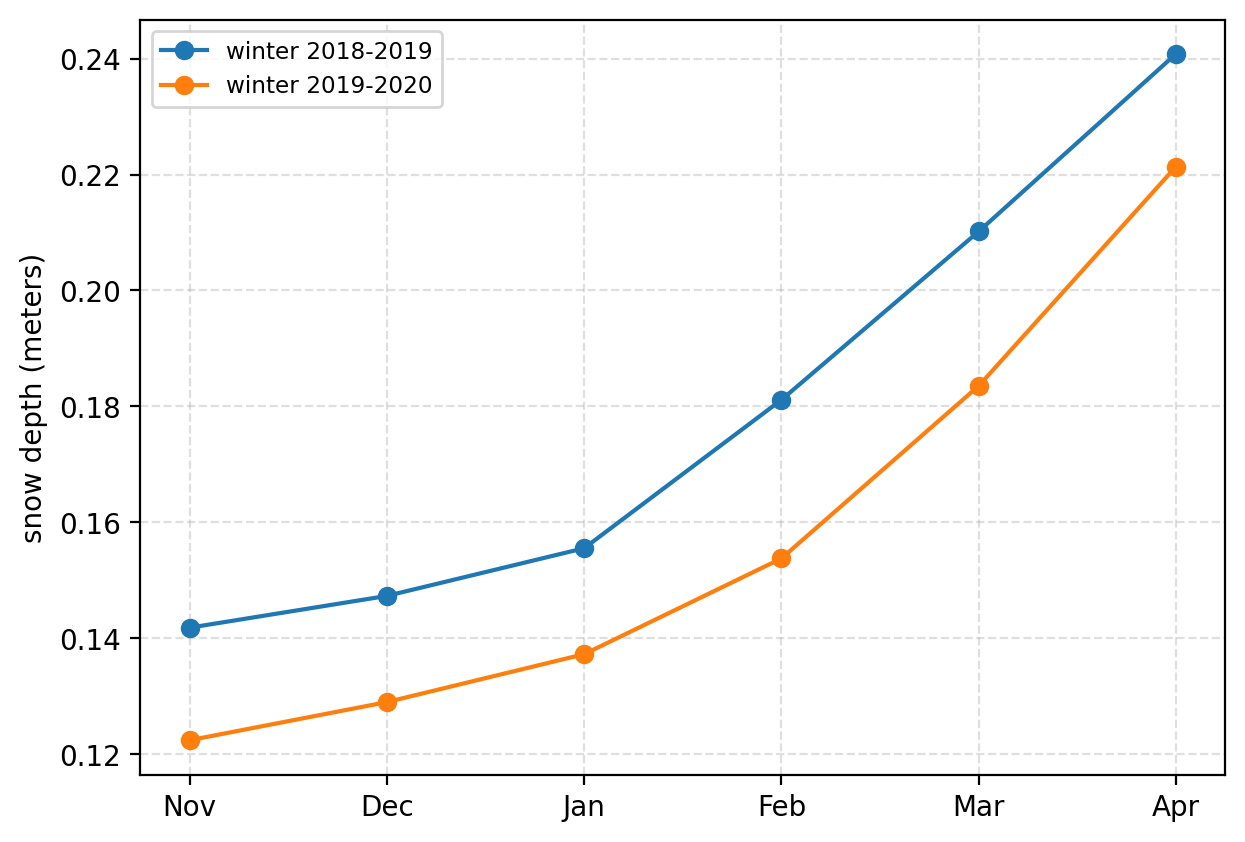

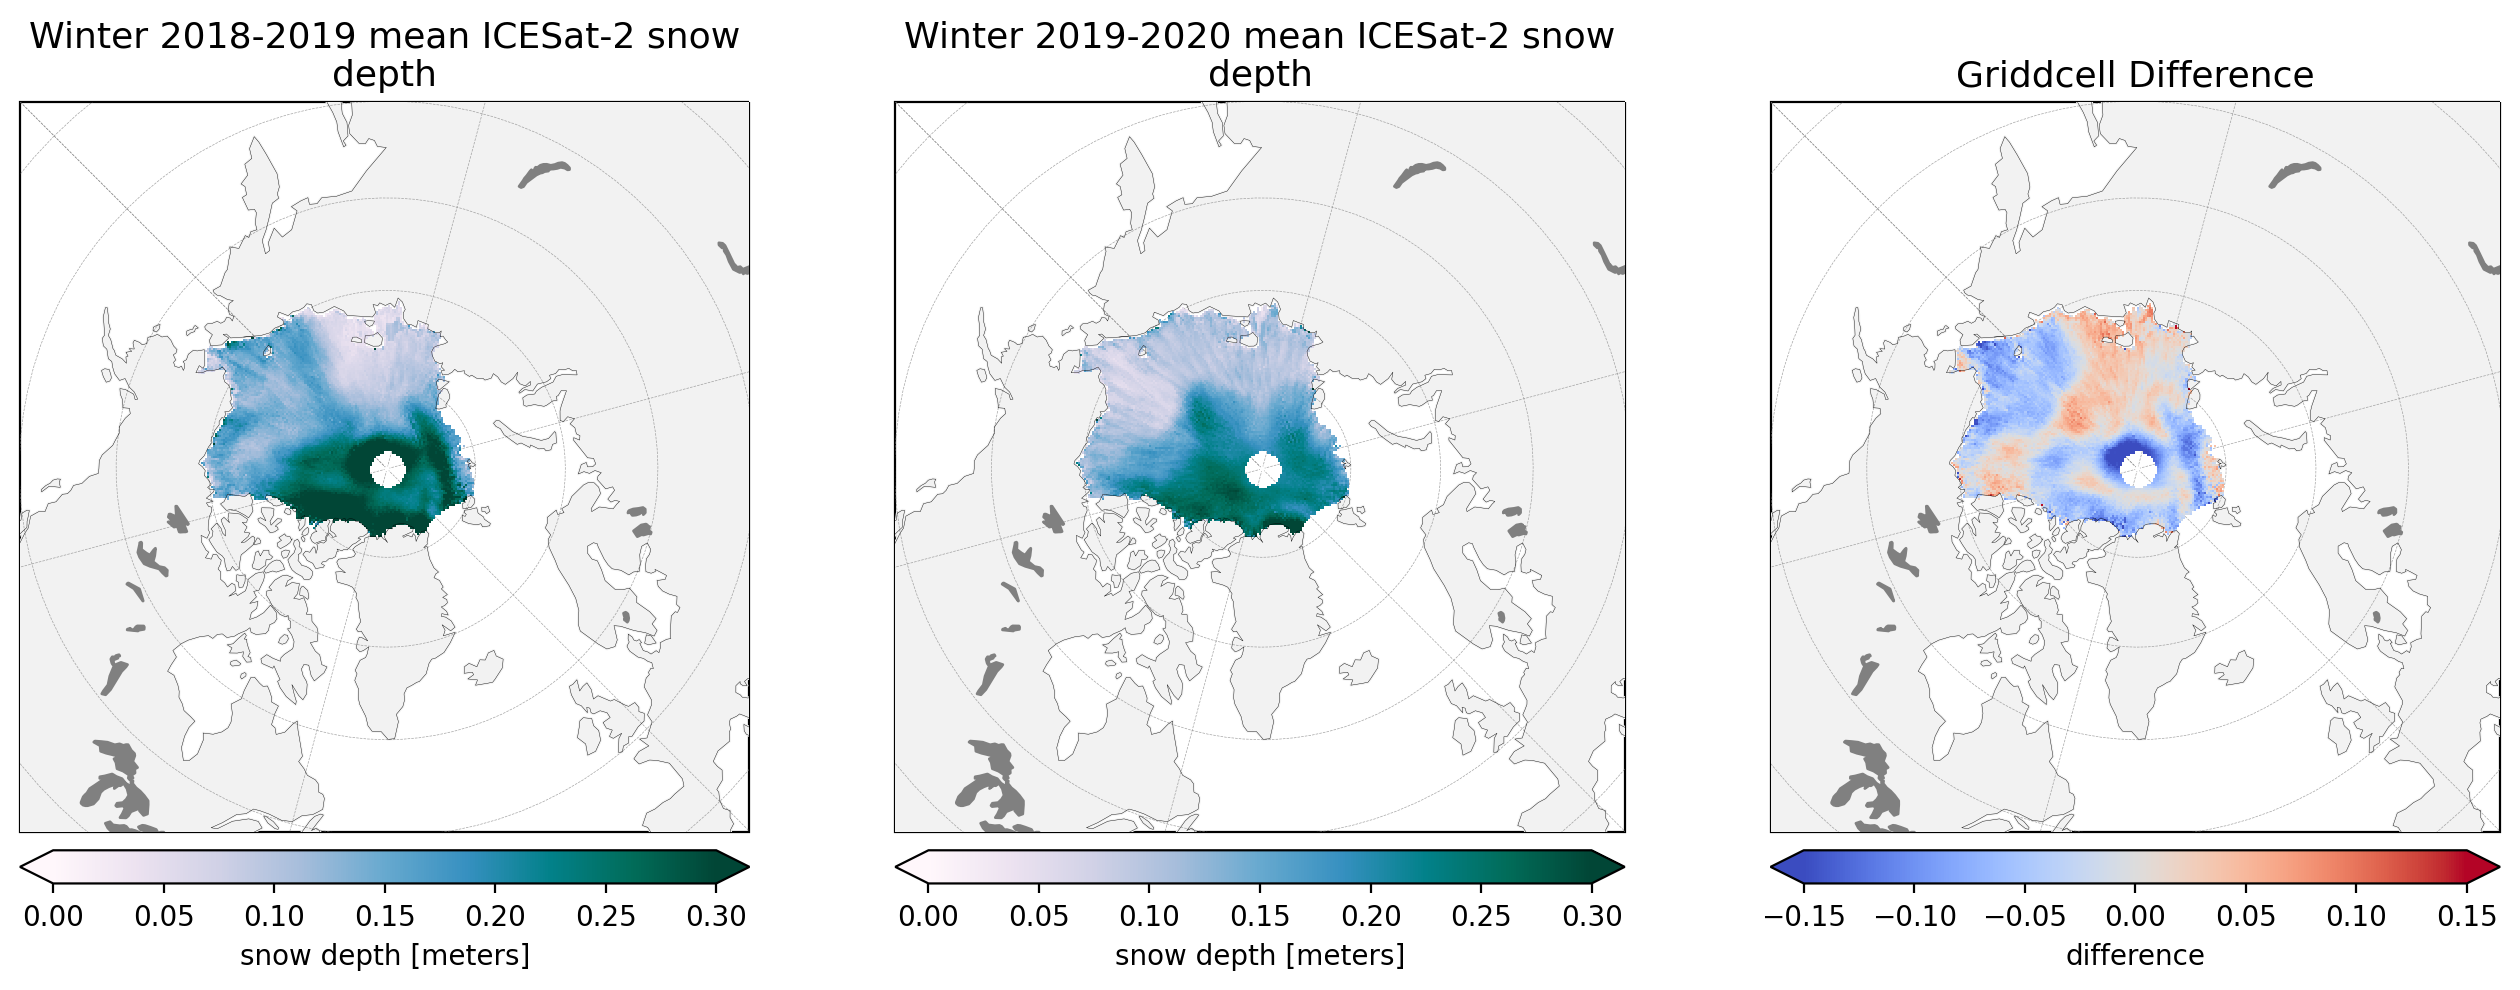

In [51]:
da = ds["snow_depth"]
plot_monthly_means(da, start_year=start_year, end_year=end_year, show_uncertainty=False) # Generate line plot

da_mean = compute_winter_means(da, start_year=start_year, end_year=end_year) # Compute gridcell seasonal mean 
arcticComparisonMaps(data1=da_mean.isel(time=0), title1="Winter "+ start_year + "-" + str(int(start_year)+1) + " mean ICESat-2 snow depth", 
                     data2=da_mean.isel(time=1), title2="Winter "+ str(int(start_year)+1) + "-" + str(int(start_year)+2) + " mean ICESat-2 snow depth", 
                     vmin=0, vmax=0.3, vmin_diff=-0.15, vmax_diff=0.15, cmap="PuBuGn")

## OSI-SAF ice type
Ice type is categorized as a binary value of first year ice (0) or multi-year ice (1).

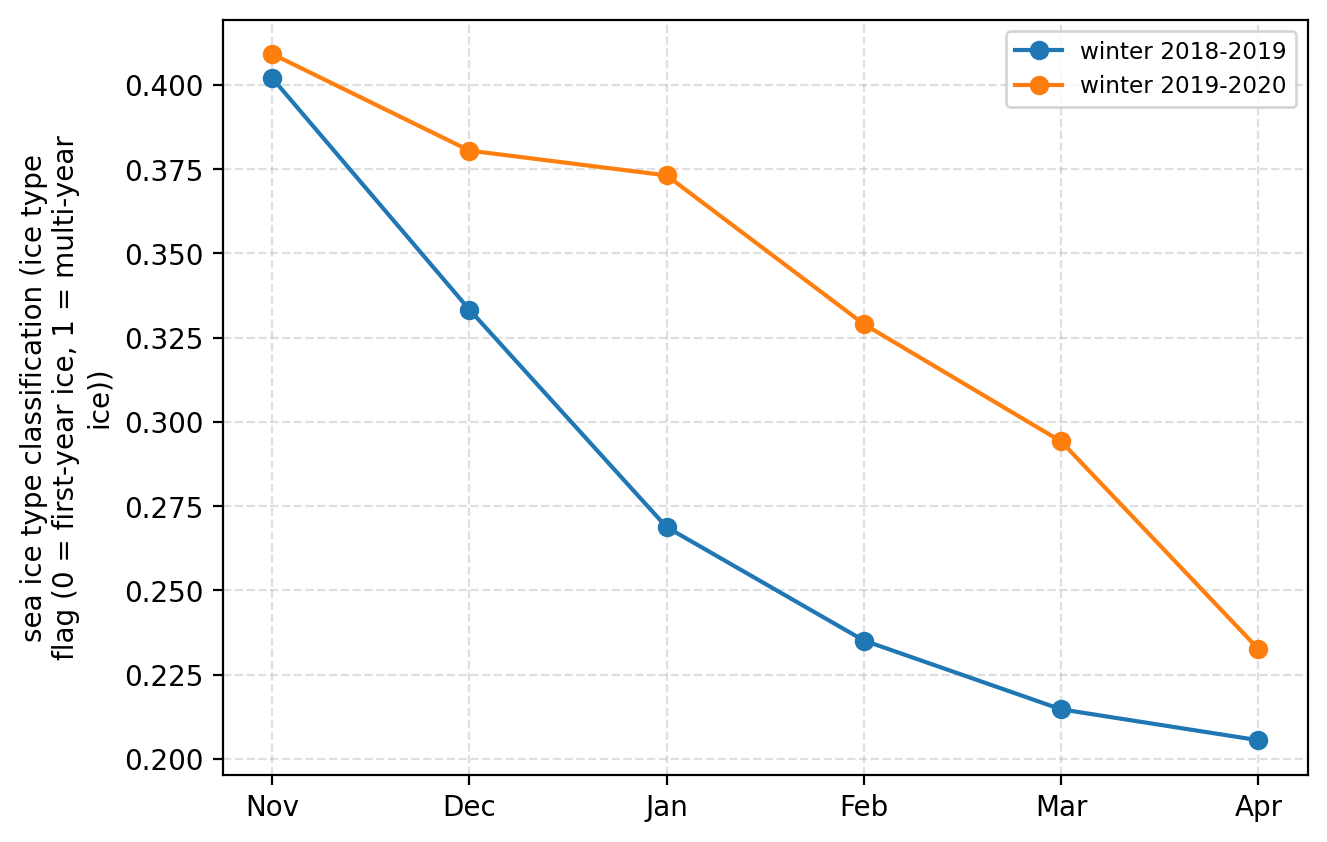

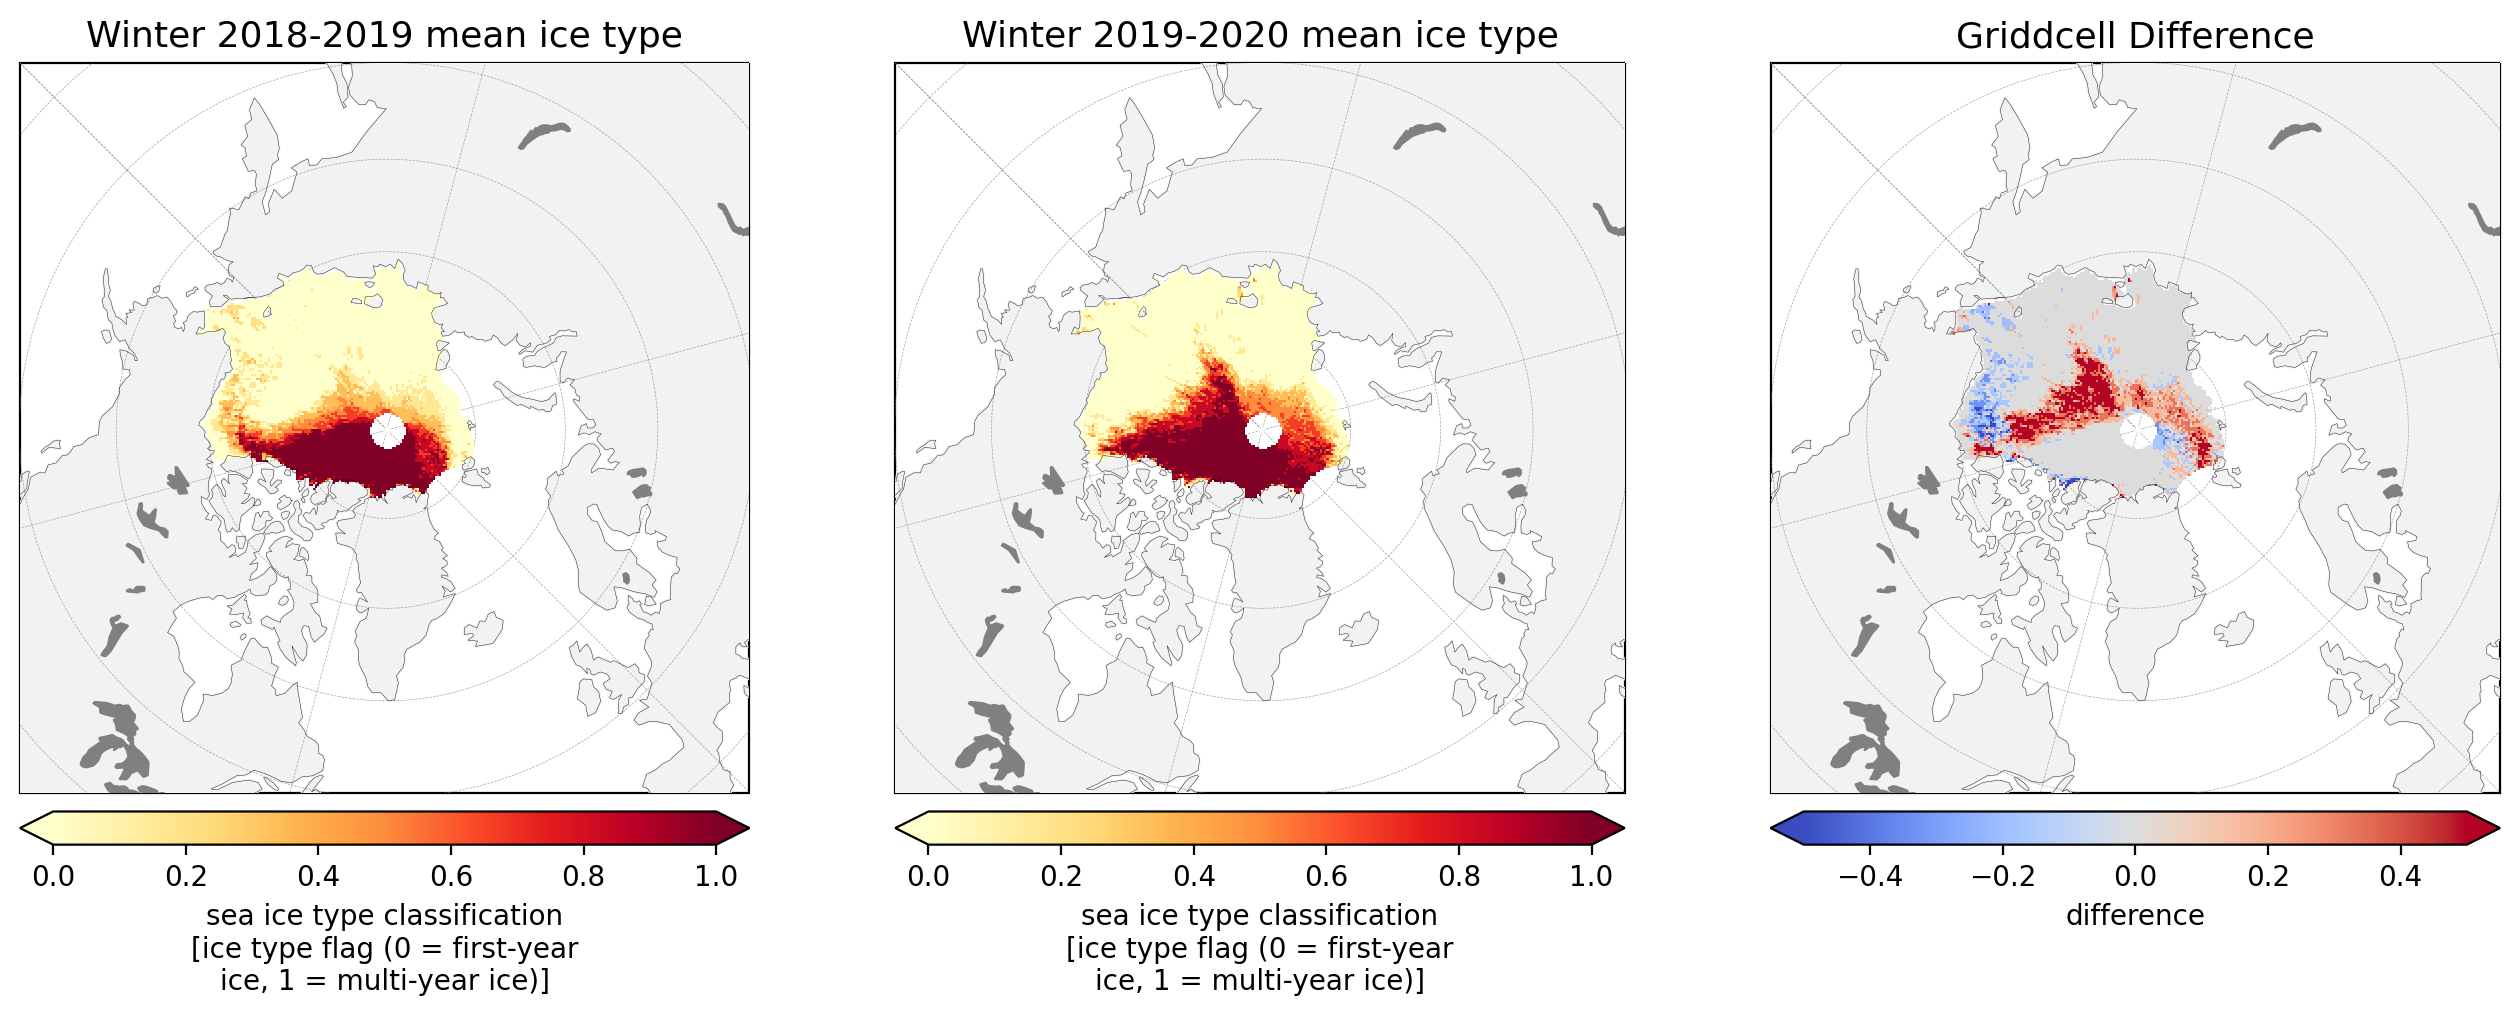

In [52]:
da = ds["ice_type"]
plot_monthly_means(da, start_year=start_year, end_year=end_year, show_uncertainty=False) # Generate line plot

da_mean = compute_winter_means(da, start_year=start_year, end_year=end_year) # Compute gridcell seasonal mean 
arcticComparisonMaps(data1=da_mean.isel(time=0), title1="Winter "+ start_year + "-" + str(int(start_year)+1) + " mean ice type", 
                     data2=da_mean.isel(time=1), title2="Winter "+ str(int(start_year)+1) + "-" + str(int(start_year)+2) + " mean ice type", 
                     vmin=0, vmax=1, vmin_diff=-0.5, vmax_diff=0.5, cmap="YlOrRd") 

## ERA5 2-meter temperature 

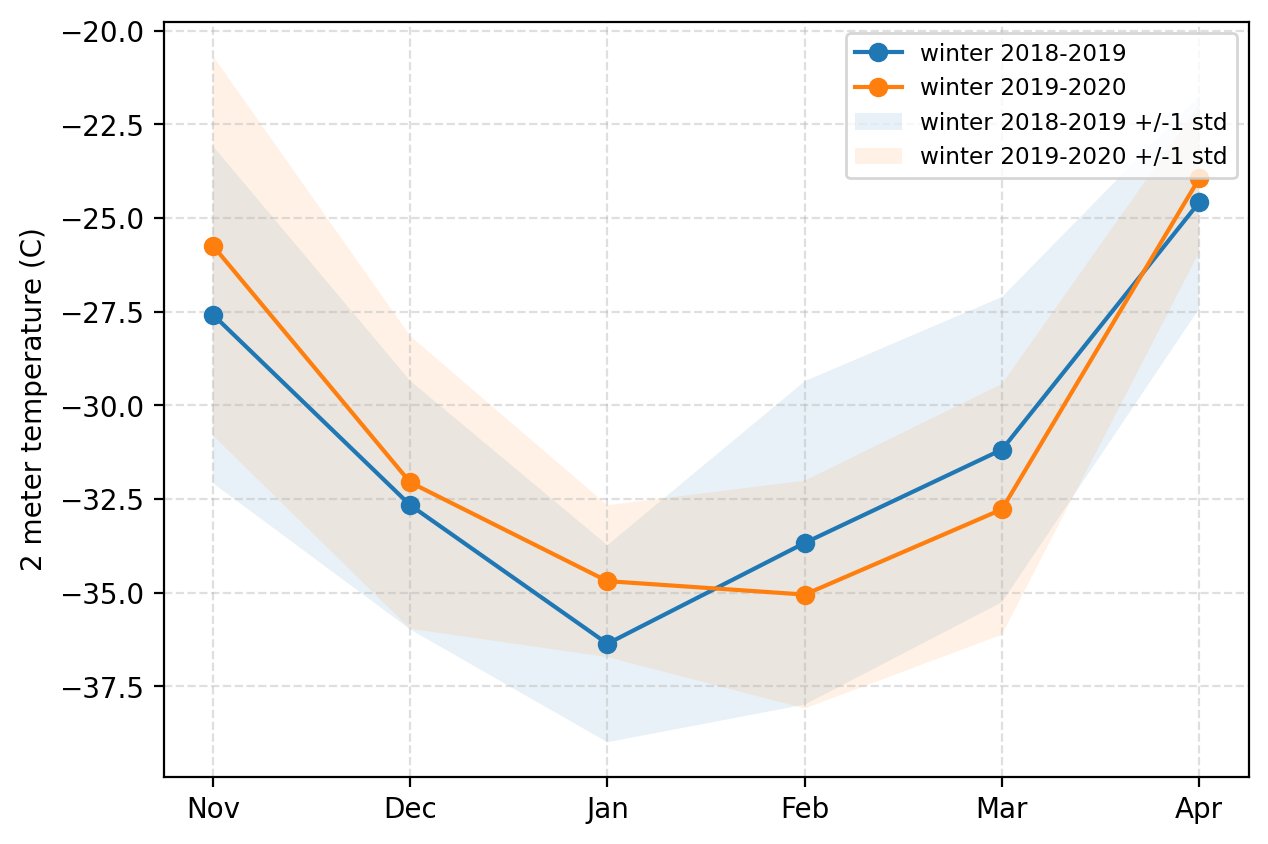

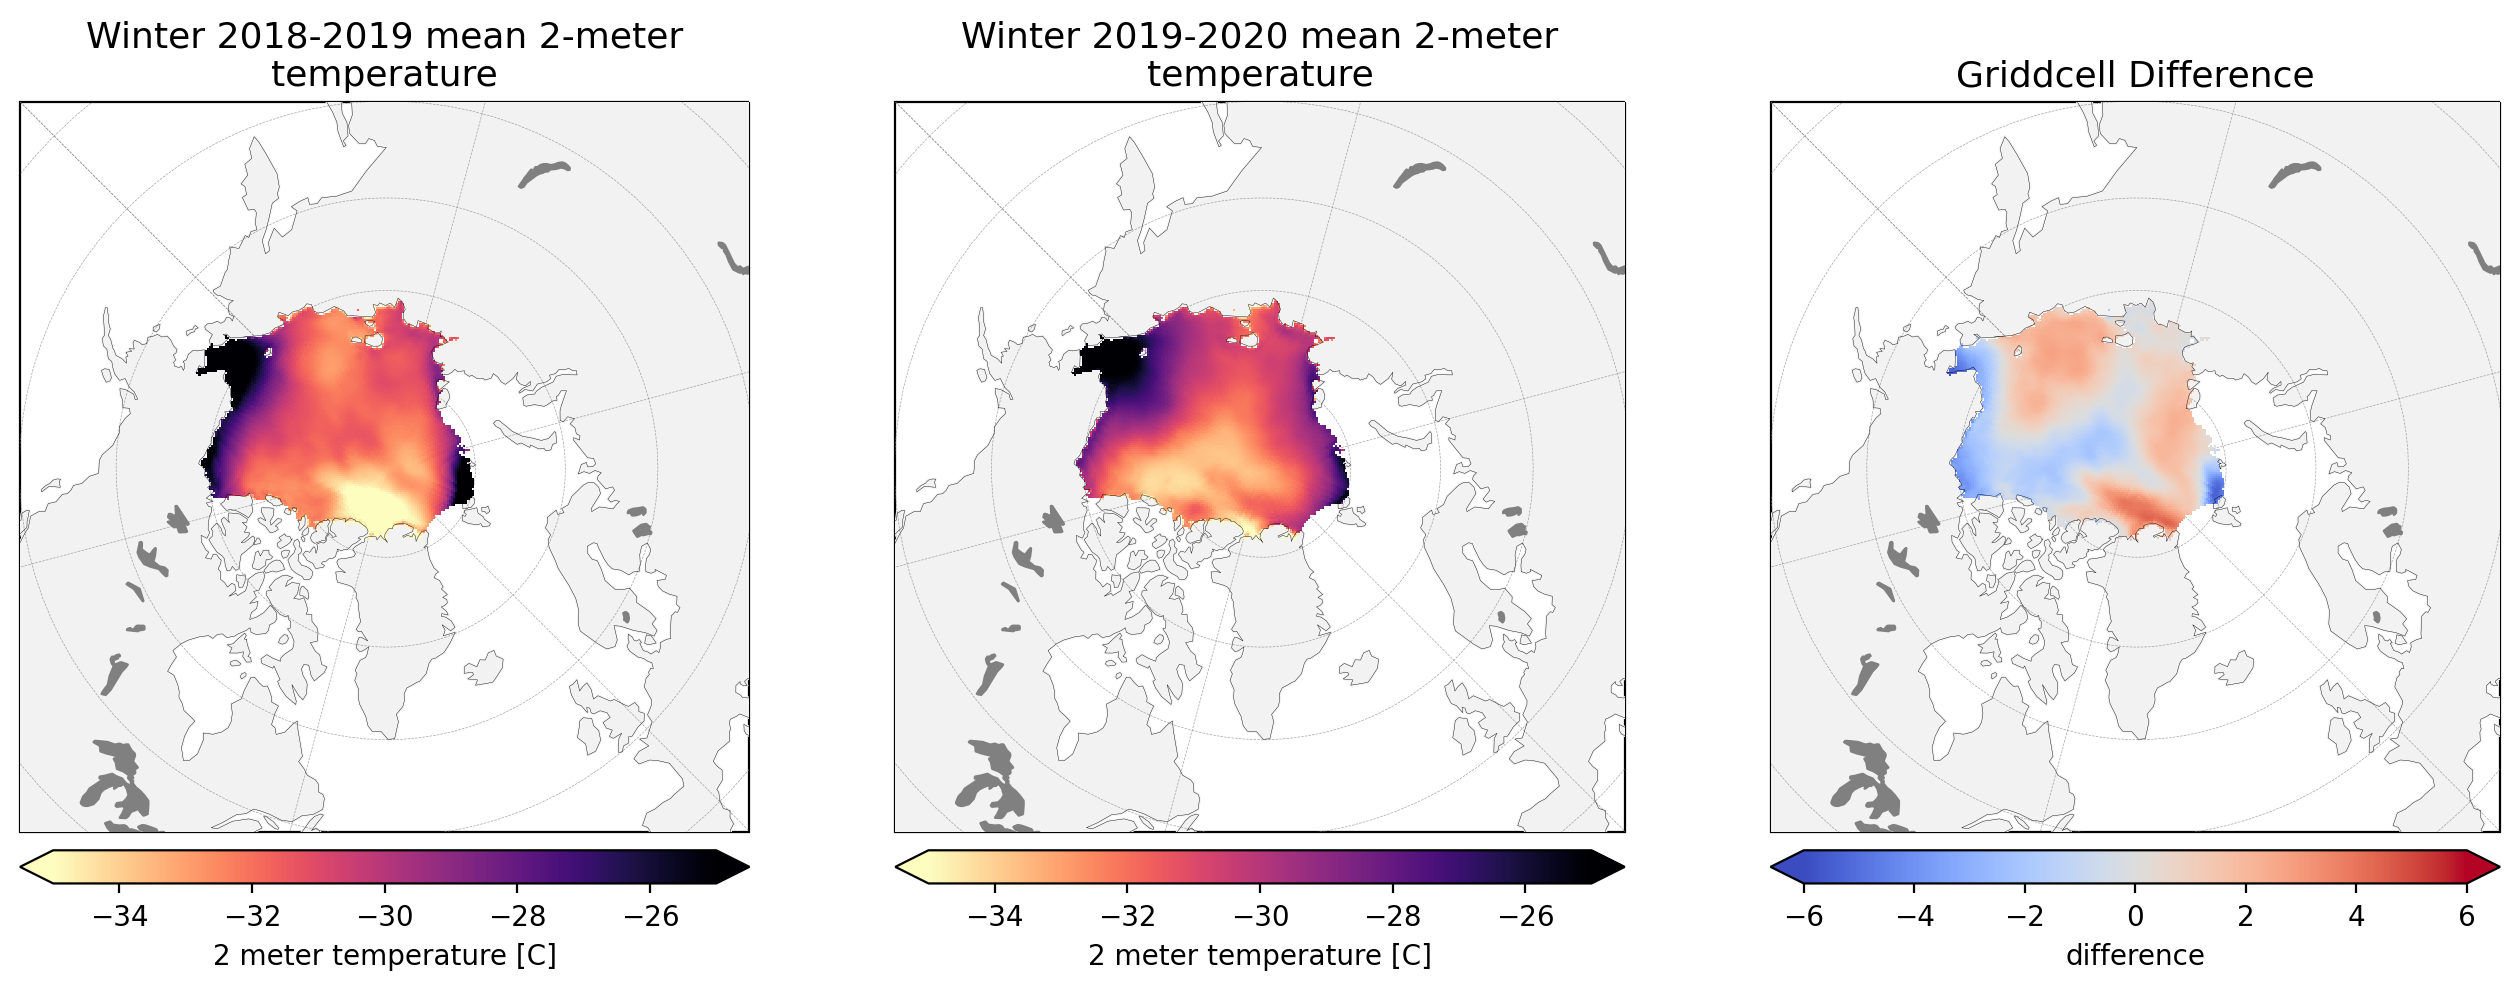

In [53]:
da = ds["t2m"]
plot_monthly_means(da, start_year=start_year, end_year=end_year) # Generate line plot

da_mean = compute_winter_means(da, start_year=start_year, end_year=end_year) # Compute gridcell seasonal mean 
arcticComparisonMaps(data1=da_mean.isel(time=0), title1="Winter "+ start_year + "-" + str(int(start_year)+1) + " mean 2-meter temperature", 
                     data2=da_mean.isel(time=1), title2="Winter "+ str(int(start_year)+1) + "-" + str(int(start_year)+2) + " mean 2-meter temperature", 
                     vmin=-35, vmax=-25, vmin_diff=-6, vmax_diff=6, cmap="magma_r")

## ERA5 mean surface downward long-wave radiation flux

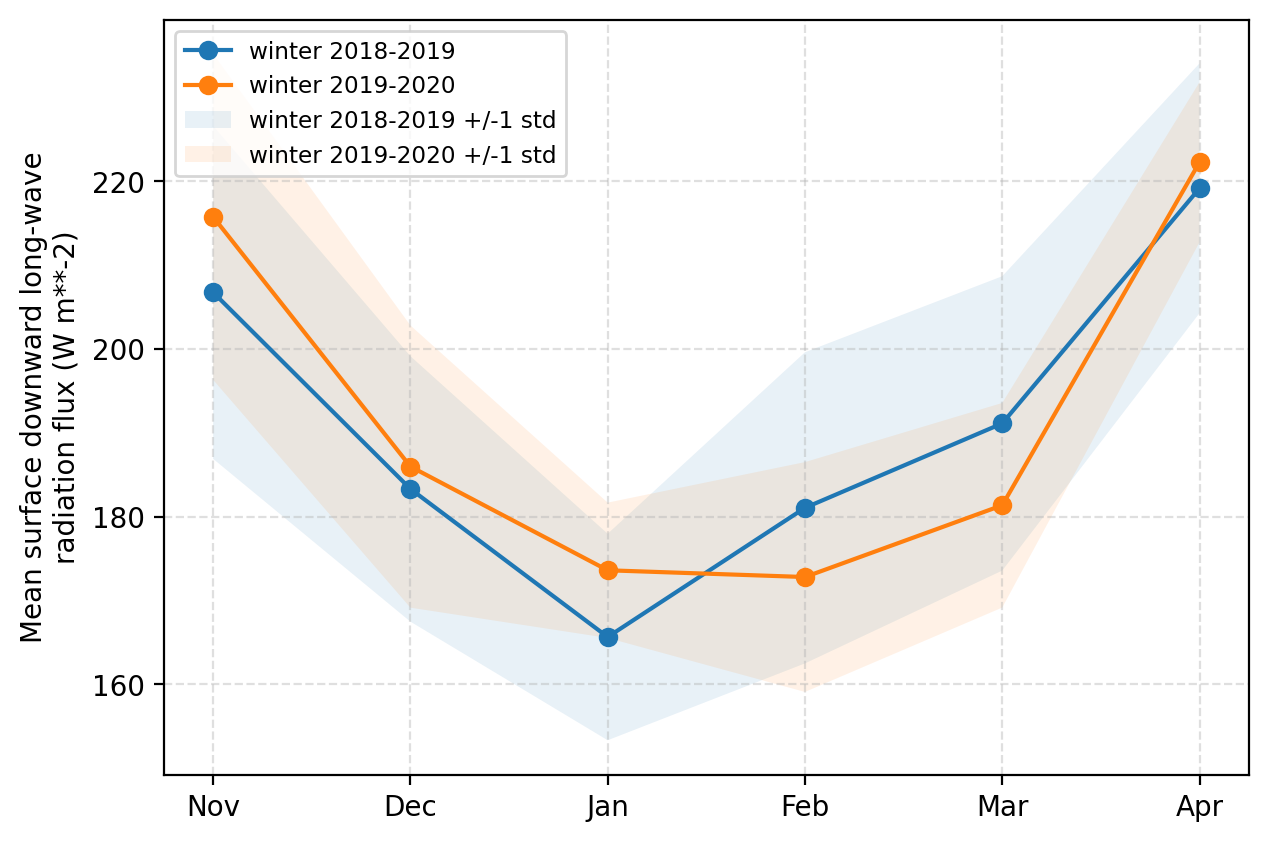

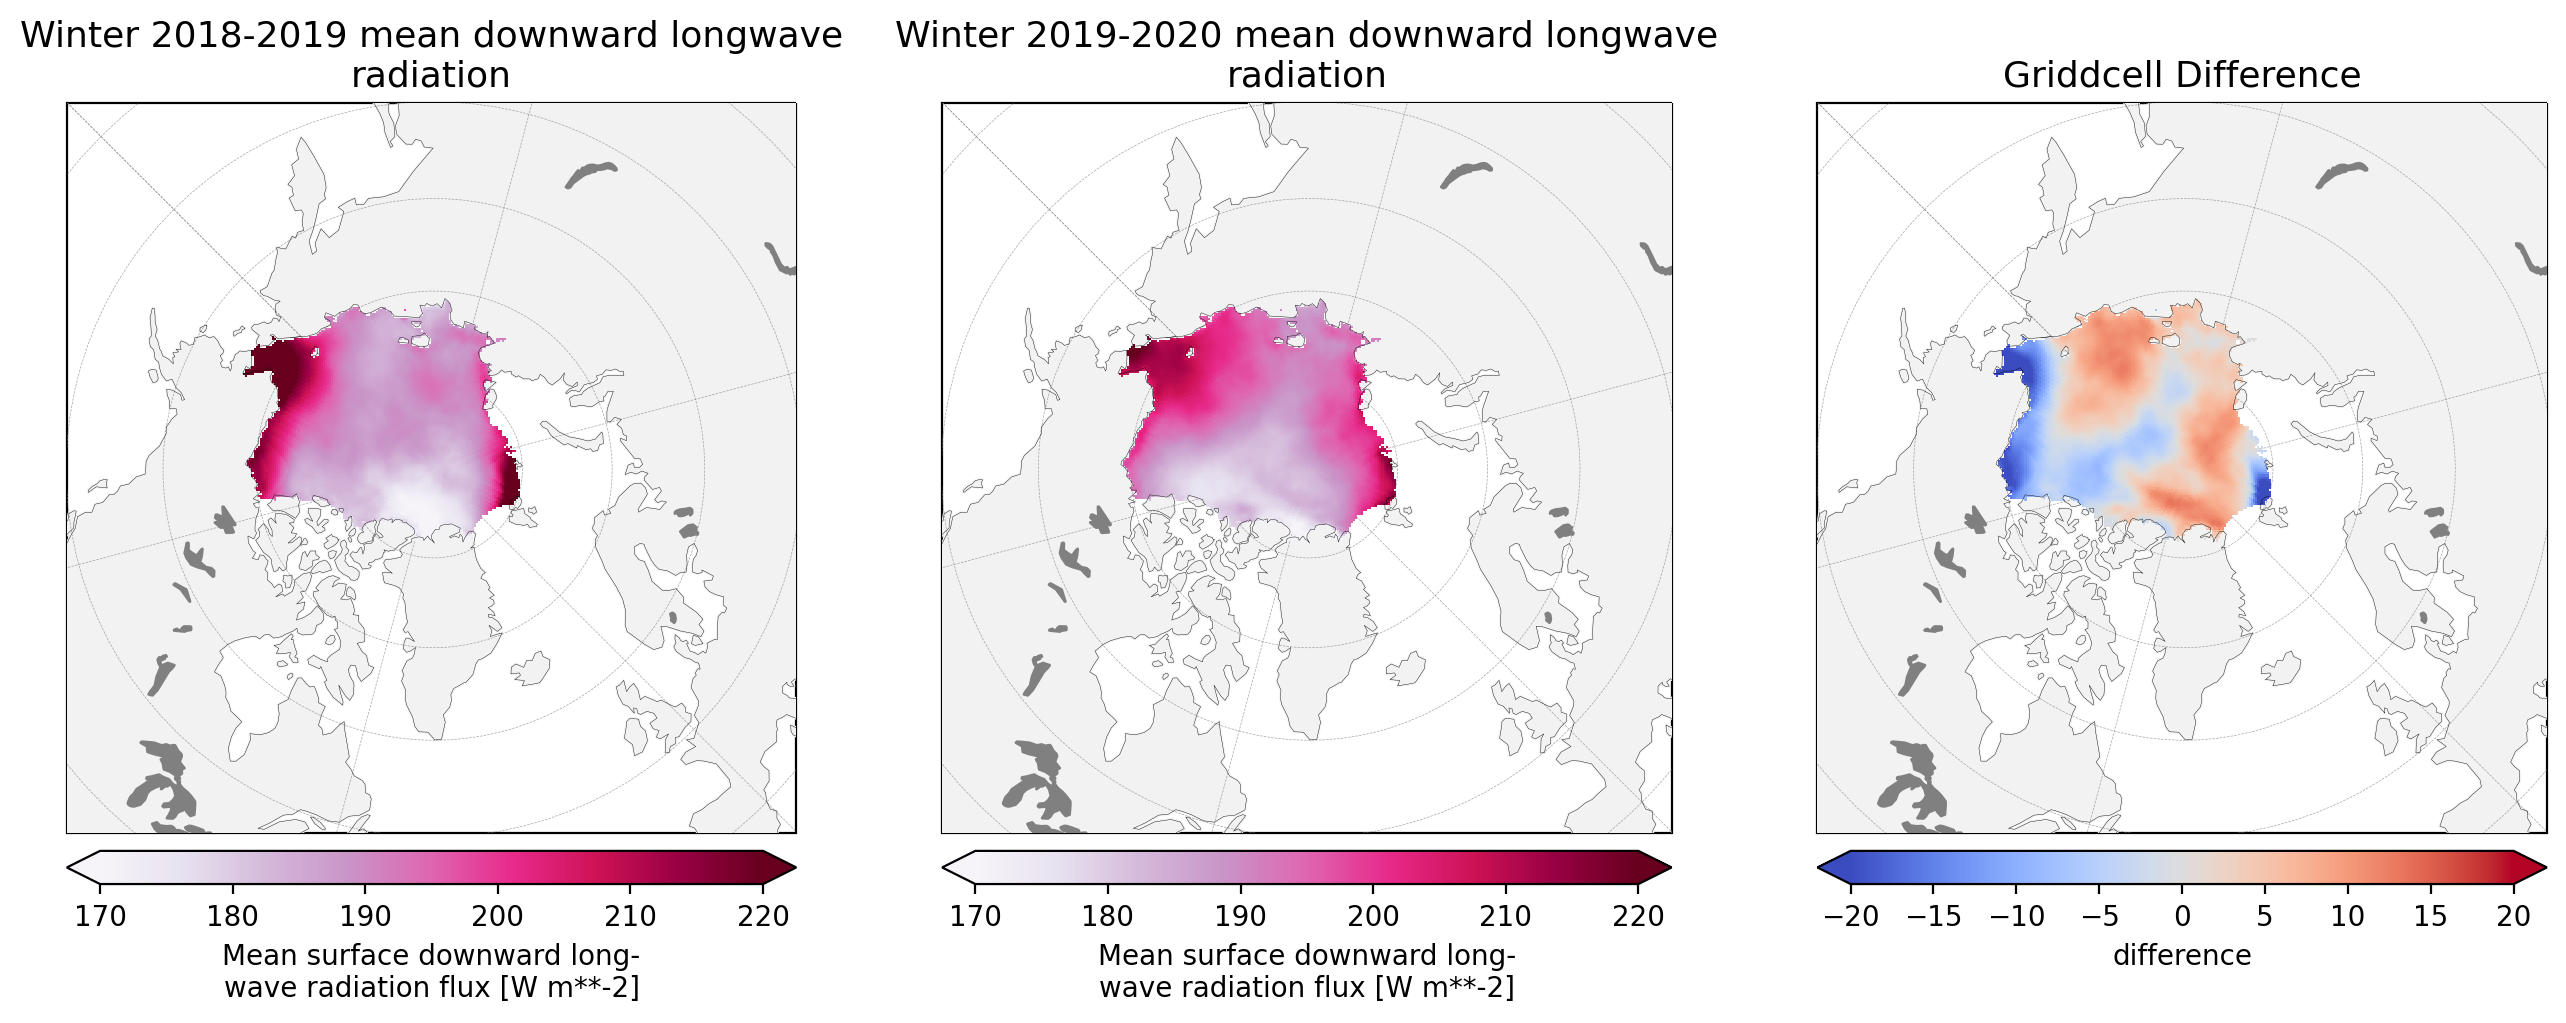

In [54]:
da = ds["msdwlwrf"]
plot_monthly_means(da, start_year=start_year, end_year=end_year) # Generate line plot

da_mean = compute_winter_means(da, start_year=start_year, end_year=end_year) # Compute gridcell seasonal mean 
arcticComparisonMaps(data1=da_mean.isel(time=0), title1="Winter "+ start_year + "-" + str(int(start_year)+1) + " mean downward longwave radiation", 
                     data2=da_mean.isel(time=1), title2="Winter "+ str(int(start_year)+1) + "-" + str(int(start_year)+2) + " mean downward longwave radiation", 
                     vmin=170, vmax=220, vmin_diff=-20, vmax_diff=20, cmap="PuRd")